# Links:
[sigfox configuration](https://build.sigfox.com/sigfox-radio-configurations-rc)


[wireless and mobile networking](https://www.cse.wustl.edu/~jain/cse574-16/)

[Sigfox network emulator](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.sigfox.com/center/download/SIFOX%20network%20emulator%20User%20Guide_0.pdf)

[ofdm and channel response example](https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html)

[concepts of ODFM](https://rfmw.em.keysight.com/wireless/helpfiles/89600b/webhelp/subsystems/wlan-ofdm/content/ofdm_basicprinciplesoverview.htm)

[wireless channel simulation MATLAB](https://www.mathworks.com/discovery/channel-model.html#:~:text=A%20channel%20model%20is%20a,travels%20through%20the%20wireless%20medium.)

In [1]:
# import simpy
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class Space(object):
    def __init__(self, env, num_worker):
        self.env = env
        self.worker = simpy.Resource(env, num_worker)

In [3]:
from scipy.spatial.transform import Rotation as R

In [4]:
class Agent(object):
    def __init__(self, **kwargs):
        self.gp = kwargs['gp'] # global position
        self.ln = kwargs['ln'] # number of NLOS paths
        self.o = kwargs['o'] # euler angle
        # self.t = kwargs['t'] direction vector
        self.phi = kwargs['phi'] # beamforming angle

In [5]:
global c
c = 3 * 10e8

def path_gain(f, d):
    r'''
    LOS path gain rho = c / (4 * pi * f * d) * Kappa (attenuation)
    '''
    return c / (4 * math.pi * f * d) #* kappa(f, d)

def kappa(f, d):
    r'''
    attenuation coefficient depending on freq and distance
    For mmWave, the attenuation over distance is set to 16 dB / km
    '''
    return 16 * d / 1000

def antenna_gain(phi, theta, phi_t, theta_t):
    r'''
    G = 1 for omnidirectional antennas
    G = sqrt(G_0) when angle in range or 0 when angle out of antennas range for other antennas
    phi: [phi_0, phi_1] pitch range
    theta: [theta_0, theta_1] 
    '''
    # if 
    return np.sqrt(4 * math.pi / (theta[1] * phi[1]))

def steering_vector():
    ...

def channel_matrix(d, fc, fk, B, delta_f, phi, theta, phi_t, theta_t):
    r'''
    channel matrix modeling channel response for k-th subcarrier
    d: distance between station and equipment (m)
    fc: central freqency (Hz)
    fk: k-th subcarrier freq(Hz)
    B: Synchronization offset
    '''
    ck = fc / fk                    # ration between central freq and subcarrier freq
    tau = d / c + B                 # signal delay
    epsl = 2 * math.pi * fc * tau   # 
    kappa = 16 * d / 1000           # attenuation coef depending on signal freq and distance

    H = ck * path_gain(fc, d) * np.exp(1j * (epsl + 2 * math.pi * delta_f * tau)) * antenna_gain(phi, theta, phi_t, theta_t)

    return H

In [6]:
fc = 862e6

channel_matrix(10, 2e8, 2.1e8, 1, 1, [0,1], [0,1], 1, 1)

(-0.20149631590468647-0.3490017733935374j)

In [7]:
n = 100
n_s = 20

coordinate = np.random.random([n, 3])
station_idx = np.random.choice(n, n_s)
bs = coordinate[station_idx]
ue = coordinate[~station_idx]

In [8]:
from scipy.io.wavfile import read, write

In [20]:
np.random.randint(1, 10, 2)

array([6, 8])

/tmp/ipykernel_1885/937089714.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = read('sample1.wav')


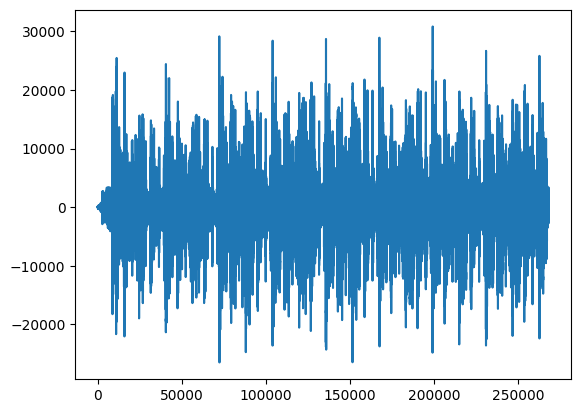

In [9]:
fs, sig = read('sample1.wav')

plt.plot(sig[:, 1])

# OFDM

## OFDM - Transmitting

In [32]:
K = 64 # num of subcarriers
cp = K // 4 # cyclic prefix
p = 8 # pilot carries per OFDM block
pilot_val = 3 + 3j

carriers = np.arange(K)
pilots = carriers[::K//p]
pilots = np.hstack([pilots, carriers[-1]])

data = np.delete(carriers, pilots)

In [33]:
from bitstring import BitStream, BitArray

In [34]:
# mapping 4 bits-16QAM 135 mbps
mu = 4 # bits per symbol
payload_bits = len(data) * mu
mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,    
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

demapping_table = {key:val for val, key in mapping_table.items()}

In [12]:
def serial2parallel(sig_in, mu, n):
    r'''
    serial to parallel converter, groups the bits for OFDM frame into groups of mu bits
    mu: bits per symbol
    n: length of data (excluding pilots)
    '''
    return sig_in.reshape((n, mu))

def mapping(bs, map_table):
    r'''
    map bits under QAM modulation
    '''
    return np.array([map_table[tuple(i)] for i in bs])

In [38]:
def ofdm_symbol(qam, K, pilots, pilot_val, data):
    r'''
    allocation of different subcarriers with data and pilots
    '''
    symbol = np.zeros(K, dtype=complex)
    symbol[data] = qam
    symbol[pilots] = pilot_val


    return symbol

def idft(sig):
    r'''
    ofdm carries data can be transformed to time domain
    '''
    return np.fft.ifft(sig)

def add_cp(sig_t, cp):
    r'''
    add cyclic prefix to signal in time domain to avoid inteference
    cp: length of cyclic prefix
    '''
    return np.hstack([sig_t[-cp:], sig_t])

In [39]:
def ofdm_tx(sig, mu, n, mapping_table, K, data, pilots, pilot_val, cp):
    bit_paralle = serial2parallel(sig, mu, len(data)) #s/p
    qam_symbol = mapping(bit_paralle, mapping_table) # QAM modulation
    symbol_with_pilots = ofdm_symbol(qam_symbol, K, pilots, pilot_val, data) # Adding pilots
    symbol_carier = idft(symbol_with_pilots) # orthogonal carrier
    symbol_cp = add_cp(symbol_carier, cp) # cyclic prefix

    return symbol_cp


In [42]:
bit_stream = np.random.binomial(n=1, p=.5, size=(payload_bits,)) # bit data (in freq domain?)

tx = ofdm_tx(bit_stream, mu, n, mapping_table, K, data, pilots, pilot_val, cp)

## Channel model

In [ ]:
# precoding

## OFDM - Receiving

In [56]:
def channeling(sig, channel_response):
    r'''
    model wireless channel with impluse response - channel response 
    add some noise maybe
    '''
    output = np.convolve(sig, channel_response)
    signal_power = np.mean(abs(output ** 2))
    snr = 10
    sigma2 = signal_power * 10 ** (-snr /10) # noise power based on signal power and SNR
    noise = np.sqrt(sigma2/2) * (np.random.randn(*output.shape) + 1j * np.random.randn(*output.shape))

    return output #+ noise


def remove_cp(sig_t, cp, K):
    r'''
    remove cyclic prefix
    a window of K samples is extracted
    '''
    return sig_t[cp:(cp+K)]

def dft(sig_t):
    return np.fft.fft(sig_t)

In [43]:
def ofdm_rx(sig, channel, K, cp):
    r'''
    receiving process of ofdm
    '''
    ofdm_rx = remove_cp(sig, cp, K)
    return dft(ofdm_rx)

In [58]:
ofdm_rx = remove_cp(ofdm_cp, cp, K)
ofdm_demod = dft(ofdm_rx)

/home/yuk/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


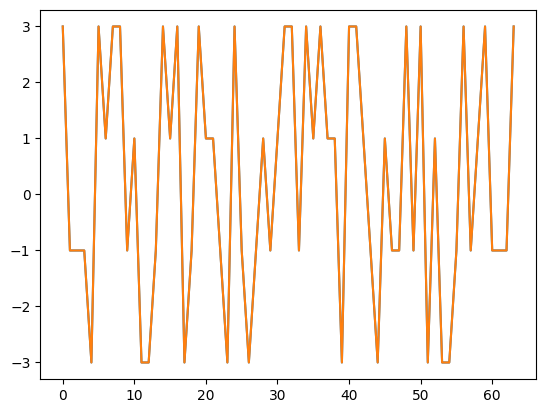

In [61]:
plt.plot(ofdm_demod)
plt.plot(symbol)

## Okumura/Hata model (page 7)
Note: for transmission between antennas

- atenna height 30-1000 m
- region radius 1-100 km
- carrier freq 500-1500 MHz

$$PL_{OK}(d)[dB] = PL_F + A_{MU}(f,d)-G_{RX}-G_{TX}+G_{AREA}$$
$G_{RX}$ - gain for receiving antenna, $G_{TX}$ - gain for transmitting antenna, $G_{AREA}$ - environment gain (practical value), $A_{MU}(f,d)$ - attenuation factor (practical value). 

In [ ]:
def path_loss_hata(fc, d, ht, hr, etype):
    r'''
    calculating the path loss (dB) based on hata model
    fc: carrier freq
    d: distance between transmitter and receiver
    '''